# MRI reconstruction from multicoil data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
#from skimage.metrics import structural_similarity as ssim
from common.evaluate import *
from pytorch_msssim import ms_ssim
import pickle
from common.subsample import MaskFunc

from DIP_UNET_models.unet_and_tv.train_unet import UnetMRIModel

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu = 2
    torch.cuda.set_device(gpu)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


# Loading MRI measurement

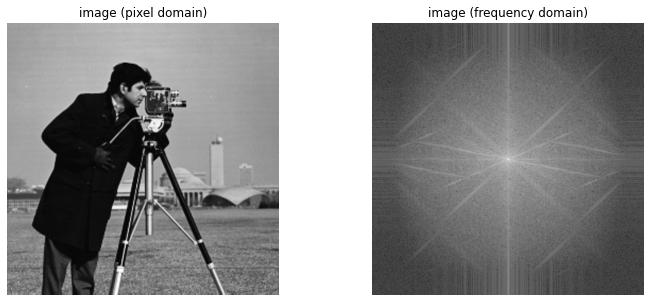

In [2]:
path = "./out_of_distribution_image/cameraman.png"
img_pil = Image.open(path)
img_np = np.array([pil_to_np(img_pil)[0]])
img_np = img_np / np.max(img_np)
img2 = torch.tensor([img_np,torch.zeros(img_np.shape)]).permute(1,2,3,0)
slice_ksp_torchtensor = transform.fft2(img2)

imgg = transform.complex_abs(transform.ifft2(slice_ksp_torchtensor)).cpu().data.numpy() ### sanity check for fourier operators
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.imshow(imgg[0],"gray")
ax.set_title("image (pixel domain)")
ax.axis("off")
ax = fig.add_subplot(122)
ax.imshow(np.log(transform.complex_abs(slice_ksp_torchtensor[0]).data.cpu().numpy()),"gray")
ax.set_title("image (frequency domain)")
ax.axis("off")
plt.show()

### Define ConvDecoder

In [3]:
in_size = [4,4]
kernel_size = 3
num_channels = 128
num_layers = 6
strides = [1]*(num_layers-1)
output_depth = 2
out_size = img_np[0].shape

parnet = convdecoder(out_size,in_size,output_depth,
                     num_layers,strides,num_channels, act_fun = nn.ReLU(),
                     skips=False,need_sigmoid=False,bias=True, need_last = True,
                     kernel_size=kernel_size,upsample_mode="nearest").type(dtype)
print(parnet,"\n")
print("#parameters =",num_param(parnet))

[(11, 11), (28, 28), (74, 74), (195, 195), (512, 512)]
conv_model(
  (act_fun): ReLU()
  (net1): Sequential(
    (1): Upsample(size=(11, 11), mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Upsample(size=(28, 28), mode=nearest)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Upsample(size=(74, 74), mode=nearest)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Upsample(size=(195, 195), mode=nearest)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, a

### Under-sample the frequency representation by a factor of 4

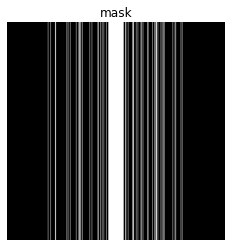

In [4]:
try: # if the file already has a mask
    temp = np.array([1 if e else 0 for e in f["mask"]])
    temp = temp[np.newaxis].T
    temp = np.array([[temp]])
    mask = transform.to_tensor(temp).type(dtype).detach().cpu()
except: # if we need to create a mask
    desired_factor = 4
    undersampling_factor = 0
    tolerance = 0.03
    while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
        mask_func = MaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
        mask1d = var_to_np(mask)[0,:,0]
        undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]
# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], img_np.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((img_np.shape[1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()
plt.imshow(mask2d,"gray")
plt.title("mask")
plt.axis("off")
plt.show()

In [5]:
def get_scale_factor(net,num_channels,in_size,ksp_tt,scale_out=1,scale_type="norm"): 
    ### get norm of deep decoder output
    # get net input, scaling of that is irrelevant
    shape = [1,num_channels, in_size[0], in_size[1]]
    ni = Variable(torch.zeros(shape)).type(dtype)
    ni.data.uniform_()
    # generate random image
    try:
        out_chs = net( ni.type(dtype),scale_out=scale_out ).data.cpu().numpy()[0]
    except:
        out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
    out_imgs = channels2imgs(out_chs)
    out_img_tt = transform.root_sum_of_squares( torch.tensor(out_imgs) , dim=0)

    ### get norm of least-squares reconstruction
    orig_tt = transform.ifft2(ksp_tt)           # Apply Inverse Fourier Transform to get the complex image
    orig_imgs_tt = transform.complex_abs(orig_tt)   # Compute absolute value to get a real image
    orig_img_tt = transform.root_sum_of_squares(orig_imgs_tt, dim=0)
    orig_img_np = orig_img_tt.cpu().numpy()
    
    if scale_type == "norm":
        s = np.linalg.norm(out_img_tt) / np.linalg.norm(orig_img_np)
    if scale_type == "mean":
        s = (out_img_tt.mean() / orig_img_np.mean()).numpy()[np.newaxis][0]
    return s,ni

In [6]:
### fix scaling for ConvDecoder
scale_out = 1
scaling_factor,ni = get_scale_factor(parnet,
                                   num_channels,
                                   in_size,
                                   slice_ksp_torchtensor,
                                   scale_out=scale_out)
slice_ksp_torchtensor1 = slice_ksp_torchtensor * scaling_factor

masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor1, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image2 = transform.ifft2(masked_kspace)

measurement = slice_ksp_torchtensor1.unsqueeze(0).type(dtype) 
lsimg = lsreconstruction(measurement)

### Fit ConvDecoder

In [7]:
out = []
for img in sampled_image2:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

scale_out,sover,pover,norm_ratio,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                            num_channels=[num_channels]*(num_layers-1),
                                                            num_iter=30000,
                                                            LR=0.01,
                                                            #LR_LS=0.02,
                                                            mask = mask2d,
                                                            apply_f = forwardm,
                                                            img_noisy_var=unders_measurement,
                                                            net=parnet,
                                                            upsample_mode="free",
                                                            img_clean_var=Variable(lsest).type(dtype),
                                                            lsimg = lsimg,
                                                            find_best=True,
                                                            loss_type="MSE",
                                                            scale_out=scale_out,
                                                            net_input = ni,
                                                            OPTIMIZER = "adam"
                                                                      )

input provided
optimize with adam 0.01


In [8]:
img = parnet(parni.type(dtype))
s = img.shape
ns = int(s[1]/2) # number of slices
fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
for i in range(ns):
    fimg[0,i,:,:,0] = img[0,2*i,:,:]
    fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
# ksp has dim: (num_slices,x,y)
meas = slice_ksp_torchtensor1.unsqueeze(0) # dim: (1,num_slices,x,y,2)
mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))
ksp_dc = Fimg.clone()
ksp_dc = ksp_dc.detach().cpu()
ksp_dc[:,:,:,mask==1,:] = meas[:,:,:,mask==1,:] # after data consistency block

img_dc = transform.ifft2(ksp_dc)[0]
out = []
for img in img_dc.detach().cpu():
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]

par_out_chs = np.array(out)
par_out_imgs = channels2imgs(par_out_chs)

# deep decoder reconstruction
prec = crop_center2(root_sum_of_squares2(par_out_imgs),320,320)

In [9]:
# normalization before computing the scores
im2 = prec.copy()
im1 = crop_center2(img_np[0],320,320)
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()

In [10]:
vif_ = vifp_mscale(im1,im2,sigma_nsq=im1.mean())

In [11]:
ssim_ = ssim(np.array([im1]), np.array([im2]))
psnr_ = psnr(np.array([im1]),np.array([im2]))

dt = torch.FloatTensor
im11 = torch.from_numpy(np.array([[im1]])).type(dt)
im22 = torch.from_numpy(np.array([[im2]])).type(dt)
ms_ssim_ = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]

### Get Unet's output

In [12]:
##### input normalization for U-net
# Crop input image to given resolution if larger
crop_size = (320, 320)
sampled_image = transform.complex_center_crop(sampled_image2, crop_size)
# Absolute value
sampled_image = transform.complex_abs(sampled_image)
# Apply Root-Sum-of-Squares if multicoil data
sampled_image = transform.root_sum_of_squares(sampled_image)
# Normalize input
sampled_image, mean, std = transform.normalize_instance(sampled_image, eps=1e-11)
sampled_image = sampled_image.clamp(-6, 6)

In [13]:
### Load a pre-trained Unet (trained on 4x accelerated multi-coil measurements of the FastMRI dataset)
class args():
    def __init__(self):
        self.num_pools = 4
        self.drop_prob = 0
        self.num_chans = 32
args = args()
umdl = UnetMRIModel(args)
umdl.cuda(gpu);

checkpoint = torch.load('UNET_trained/epoch=49.ckpt', map_location='cpu')
umdl.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [14]:
unet_out = umdl( torch.from_numpy(np.array([sampled_image.data.cpu().numpy()])).type(dtype) )
unet_out_np = unet_out.data.cpu().numpy()[0]

In [15]:
orig = torch.from_numpy(crop_center2(img_np[0],320,320))
orig = transforms.normalize(orig, mean, std, eps=1e-11)
orig = orig.clamp(-6, 6)
orig = orig.data.cpu().numpy()

##### balance the dynamic range for score computation #####
mean = mean.data.cpu().numpy()[np.newaxis][0]
std = std.data.cpu().numpy()[np.newaxis][0]

In [16]:
##### scores ######
im1_unet = orig*std+mean
im2_unet = unet_out_np*std+mean
im1_unet = (im1_unet-im1_unet.mean()) / im1_unet.std()
im1_unet *= im2_unet.std()
im1_unet += im2_unet.mean()

vif_unet = vifp_mscale(im1_unet,im2_unet,sigma_nsq=im1_unet.mean())

ssim_unet = ssim(np.array([im1_unet]),np.array([im2_unet]))
psnr_unet = psnr(np.array([im1_unet]),np.array([im2_unet]))
dt = torch.FloatTensor
ms_ssim_unet = ms_ssim(torch.tensor([[im1_unet]]).type(dt), torch.tensor([[im2_unet]]).type(dt), data_range=im1_unet.max())

### Visualization

ConvDecoder --> VIF: 0.89, MS-SSIM: 0.97, SSIM: 0.886, PSNR: 28.74 
U-net       --> VIF: 0.69, MS-SSIM: 0.92, SSIM: 0.796, PSNR: 25.57 


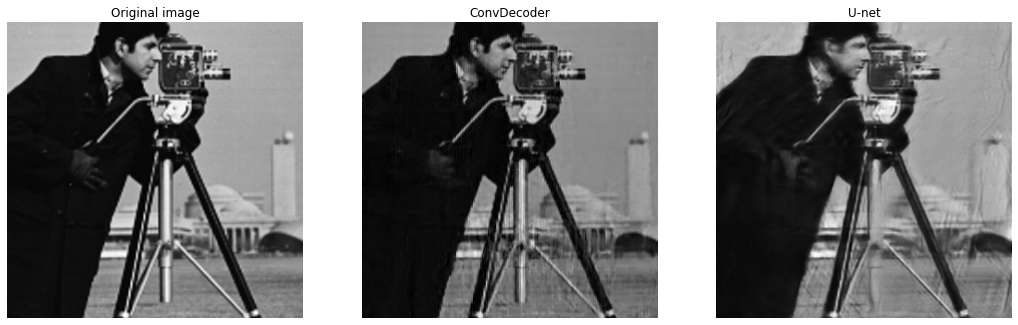

In [19]:
fig = plt.figure(figsize = (18,16)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(131)
ax1.imshow(crop_center2(img_np[0],320,320),cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "ConvDecoder") 
ax2.axis('off') 

ax3 = fig.add_subplot(133)
ax3.imshow(im2_unet,cmap='gray')
ax3.set_title( "U-net" ) 
ax3.axis('off') 

print("ConvDecoder --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.3f, PSNR: %.2f " % (vif_,ms_ssim_,ssim_,psnr_))
print("U-net       --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.3f, PSNR: %.2f " % (vif_unet,ms_ssim_unet,ssim_unet,psnr_unet))

plt.show()